In [9]:
# Célula 1: Importações e configurações
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim

from models.ar_cnn import AR_CNN

# Verifica dispositivo
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Dispositivo:", device)


Dispositivo: cuda


In [10]:
# Célula 3: Função de inferência para imagem inteira
def process_full_image(model, image, device='cuda'):
    """
    Processa uma imagem inteira utilizando o modelo AR_CNN.
    
    Args:
        model: modelo treinado.
        image: objeto PIL Image (escala de cinza).
        device: dispositivo de execução ('cuda' ou 'cpu').
        
    Retorna:
        output_image: imagem processada (objeto PIL Image).
    """
    model.eval()
    transform = transforms.ToTensor()
    input_tensor = transform(image).unsqueeze(0).to(device)  # Formato: [1, 1, H, W]
    
    with torch.no_grad():
        output_tensor = model(input_tensor)
        
    output_tensor = output_tensor.squeeze(0).cpu()
    to_pil = transforms.ToPILImage()
    output_image = to_pil(output_tensor)
    return output_image


In [11]:
# Célula 4: Função para calcular PSNR e SSIM
def compute_metrics(img1, img2):
    """
    Calcula PSNR e SSIM entre duas imagens.
    
    Args:
        img1, img2: objetos PIL Image (escala de cinza).
        
    Retorna:
        psnr, ssim: valores das métricas.
    """
    # Converte as imagens para arrays numpy com valores no intervalo [0,1]
    np_img1 = np.array(img1).astype(np.float32) / 255.0
    np_img2 = np.array(img2).astype(np.float32) / 255.0
    
    psnr = compare_psnr(np_img1, np_img2, data_range=1.0)
    ssim = compare_ssim(np_img1, np_img2, data_range=1.0)
    return psnr, ssim


In [14]:
# Célula: Seleção aleatória de vídeo e frame

import os, random

# Diretórios base para imagens originais e processadas
original_base_dir  = "../data/frames_y/val/original"
processed_base_dir = "../data/frames_y/val/qp47"

# Lista os vídeos disponíveis (assumindo que cada subpasta é um vídeo)
videos = [v for v in os.listdir(original_base_dir) 
          if os.path.isdir(os.path.join(original_base_dir, v))]
if not videos:
    raise Exception("Nenhum vídeo encontrado em " + original_base_dir)

# Seleciona um vídeo aleatório
random_video = random.choice(videos)
print("Vídeo selecionado:", random_video)

# Define os caminhos para o vídeo (original e processado)
video_original_dir  = os.path.join(original_base_dir, random_video)
video_processed_dir = os.path.join(processed_base_dir, random_video)

# Lista os arquivos de frame disponíveis (por exemplo, arquivos .png)
frames = [f for f in os.listdir(video_original_dir) if f.endswith('.png')]
if not frames:
    raise Exception("Nenhum frame encontrado em " + video_original_dir)

# Seleciona um frame aleatório
random_frame = random.choice(frames)
print("Frame selecionado:", random_frame)

# Define os caminhos completos para o frame
original_image_path  = os.path.join(video_original_dir, random_frame)
processed_image_path = os.path.join(video_processed_dir, random_frame)

print("Caminho da imagem original:", original_image_path)
print("Caminho da imagem processada:", processed_image_path)


Vídeo selecionado: water_hdr_amazon_360p
Frame selecionado: frame_0056.png
Caminho da imagem original: ../data/frames_y/val/original/water_hdr_amazon_360p/frame_0056.png
Caminho da imagem processada: ../data/frames_y/val/qp47/water_hdr_amazon_360p/frame_0056.png


Métricas para a imagem processada (baseline):
  PSNR: 34.97 dB
  SSIM: 0.8718

Métricas para a imagem restaurada pela rede:
  PSNR: 34.80 dB
  SSIM: 0.8717


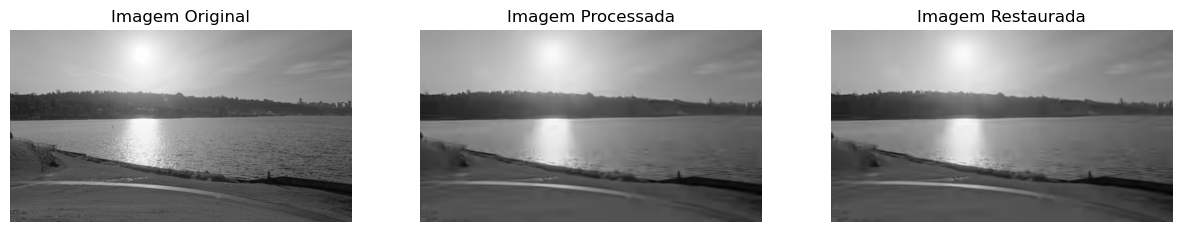

In [ ]:
# Célula: Carrega imagens, restaura com o modelo e exibe resultados

# Carrega as imagens e garante que sejam em escala de cinza
original_image  = Image.open(original_image_path).convert('L')
processed_image = Image.open(processed_image_path).convert('L')

# Inicializa o modelo e carrega os pesos
model = AR_CNN().to(device)
model.load_state_dict(torch.load("/home/lucas/VVCEnhancer/checkpoints/model_epoch_5.pth", map_location=device))
model.eval()

# Processa a imagem "processada" para restaurá-la
restored_image = process_full_image(model, processed_image, device=device)

# Calcula as métricas:
# - Baseline: imagem processada vs. original
# - Restauração: imagem restaurada vs. original
psnr_processed, ssim_processed = compute_metrics(original_image, processed_image)
psnr_restored,  ssim_restored  = compute_metrics(original_image, restored_image)

print("Métricas para a imagem processada (baseline):")
print(f"  PSNR: {psnr_processed:.2f} dB")
print(f"  SSIM: {ssim_processed:.4f}")

print("\nMétricas para a imagem restaurada pela rede:")
print(f"  PSNR: {psnr_restored:.2f} dB")
print(f"  SSIM: {ssim_restored:.4f}")

# Exibe as imagens lado a lado
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(original_image, cmap='gray')
plt.title("Imagem Original")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(processed_image, cmap='gray')
plt.title("Imagem Processada")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(restored_image, cmap='gray')
plt.title("Imagem Restaurada")
plt.axis('off')

plt.show()
